N = 128 sampling points
M matrices have been computed
linear
linear


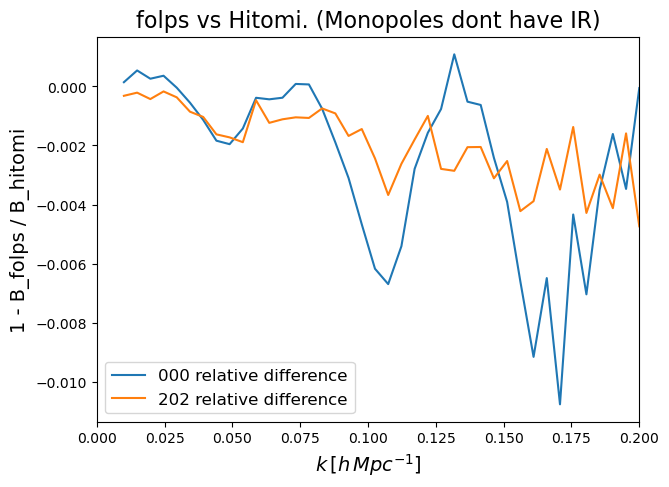

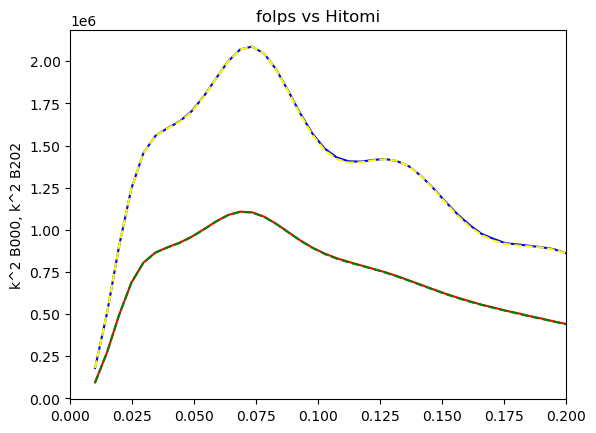

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import FOLPSD as FOLPS



precision=[62,62,62]
#precision=[18,62,62]

Omfid = -1  # for AP set > 0
APtrue = False
if Omfid > 0:
    APtrue = True

k_evb = np.linspace(0.01,0.2, num = 40) 
k_ev_bk=np.vstack([k_evb,k_evb]).T   # List of pairs of k. (B=B(k1,k2))


#omega_i = Omega_i h² 
omega_b = 0.0224;        #baryons
omega_cdm = 0.12;       #CDM
omega_ncdm = 0.000;    #massive neutrinos 
h = 0.67;                 #h = H0/100
z_pk = 0.0;                 #evaluation redshift
if z_pk < 0.0000000000001:
    APtrue = False
    Omfid = -1
    
    
CosmoParams = [z_pk, omega_b, omega_cdm, omega_ncdm, h]


inputpkT = np.loadtxt('pk_linear.txt', unpack = True)

#bias parameters
b1, b2, bs2,b3nl = 1,0,0,0;                 

#EFT parameters
alpha0, alpha2, alpha4 = 0,0,0    # PEFT(k) = (alpha0 + alpha2*mu^2+ alpha4*mu^4)  k^2 Plin(k)
ctilde = 0               #NLO counterterm
X_FoG = 0  # uses a Lorentzian Damping 1/(1+x^2), with x = X_FoG f sigma_v mu. 

#Stochatics parameters
# Noise is Pshot = PshotP * ( alphashot0 + alphashot2*(k*mu)**2 )
alphashot0 = 0;          
alphashot2 = 0;            
PshotP = 0    # =1/barn.  Poissonian shot noise
NuisanParams = [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP,X_FoG]


matrices = FOLPS.Matrices()

# output k_ev
k_ev = np.logspace(np.log10(0.01), np.log10(0.3), num = 30) # array of k_ev in [h/Mpc]
k_ev = k_evb


nonlinear = FOLPS.NonLinear(inputpkT, CosmoParams)
kh, pkl0, pkl2, pkl4 = FOLPS.RSDmultipoles(k_ev, NuisanParams, Omfid = Omfid, AP=APtrue)

# niusance parameters for the bispectrum
Pshot = 0; # This would be the same as PshopP*alphashot0 if the bispectrum were computed up to 1loop (I think!)
Bshot = 0;
c1=0
c2=0
X_FoG_bk=0

bisp_nuis_params = [b1, b2, bs2, c1,c2,Pshot,Bshot, X_FoG_bk]
bisp_cosmo_params = [(omega_cdm+omega_b+omega_ncdm)/h**2,h]

## compute quadrupole withouth IR
k_pkl_pklnw=np.array([nonlinear[0][0], nonlinear[0][1], nonlinear[0][1]])
# B000, B202_borrar = FOLPS.Bisp_Sugiyama(bisp_cosmo_params, bisp_nuis_params,
#                                    k_pkl_pklnw=k_pkl_pklnw, z_pk=z_pk, k1k2pairs=k_ev_bk,
#                                    Omfid=Omfid,precision=precision)

qpar,qperp=1,1
B000, t,t,B202_borrar, t = FOLPS.Sugiyama_Bl1l2L(k_ev_bk, bisp_nuis_params, bisp_cosmo_params, 
                                                     qpar, qperp, k_pkl_pklnw, 
                     precision=[20,20,20], 
                     f=None, 
                     renormalize=True, 
                     interpolation_method='linear')

loaded_data = np.loadtxt('Carol_monopole.txt')
k_ev_C = loaded_data[:, 0]
B000_C = loaded_data[:, 1]


## compute quadrupole with IR
precision=[62,62,62]
k_pkl_pklnw=np.array([nonlinear[0][0], nonlinear[0][1], nonlinear[1][1]])
B000_borrar, t,t,B202, t = FOLPS.Sugiyama_Bl1l2L(k_ev_bk, bisp_nuis_params, bisp_cosmo_params, 
                                                     qpar, qperp, k_pkl_pklnw, 
                     precision=[20,20,20], 
                     f=None, 
                     renormalize=True, 
                     interpolation_method='linear')

B202_C_old = np.loadtxt('bk202_hit.txt')
B202_k_old = np.loadtxt('k_new.txt')

B202_C = FOLPS.interpolation_b(k_ev, B202_k_old, B202_C_old)


fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'1 - B_folps / B_hitomi', fontsize =  14)

axs.plot(k_ev, -(B000/B000_C - 1), label=r'000 relative difference')
axs.plot(k_ev, -(B202/B202_C - 1), label=r'202 relative difference')
axs.legend(fontsize=12, loc='best')
axs.set_title('folps vs Hitomi. (Monopoles dont have IR)', fontsize=16, pad=7)

axs.set_xlim([0, 0.2])
plt.show()




plt.plot(k_ev,k_ev*k_ev*B000,ls='-',color='blue')
plt.plot(k_ev,k_ev*k_ev*B202,ls='-',color='red')
plt.plot(k_ev,k_ev*k_ev*B000_C,ls='--',color='yellow')
plt.plot(k_ev,k_ev*k_ev*B202_C,ls='--',color='green')

plt.title(r'folps vs Hitomi')
plt.ylabel('k^2 B000, k^2 B202')
plt.xlim(0,0.20)
plt.show()